# PUNCHData guide
A notebook guide to working with PUNCHData FITS files in Python

This Jupyter Notebook presents a comprehensive guide to the analysis and visualization of PUNCHData FITS files using Python. The guide leverages a suite of Python libraries, including matplotlib for data visualization, numpy for numerical operations, astropy for FITS file handling and WCS manipulation, sunpy for solar data analysis, and ndcube for multi-dimensional data handling. The notebook serves as a robust resource for researchers and scientists, providing them with the tools and knowledge to effectively manipulate and interpret PUNCHData FITS files. The guide's step-by-step approach, coupled with code snippets and detailed explanations, ensures a user-friendly experience, promoting the accessibility of PUNCHData for a wider scientific community.

# Data design principles
## Data and metadata

- Built on NDCube
    - Bundles data with associated uncertainties, world coordinate system (WCS), and metadata
- Transparent & self-describing metadata
- Fully standards (FITS 4.0) compliant
- Human enjoyably readable
- Uses FITS’s multidimensional data capabilities to represent polarization, uncertainty, etc.

# Data pipeline
## Overview

- Combining observations from four satellites into one virtual observatory with modern pipeline tools
- Prefect for pipeline orchestration
- NDCube for data handling
- Ease of use / extensibility
- Robust documentation

# Data products

## Background

- Preliminary synthetic PUNCH data generated from GAMERA model data
- Simulates real PUNCH Level 3 data
- Does not include a starfield or F-corona
- The next iteration of this data will include realistic noise

## Filenames

PUNCH_L3_PAM_20230704000000_v1.fits

- Spacecraft: PUNCH
- Data level : Level 3
- Product code : PAM (Polarized low-noise mosaic)
- Datestring : 20230704000000
- Version number : v1 (optional, used for data reprocessing)

## Primary data

![PUNCH L3 Data](PUNCH_L3_data.png)

- L3 - Level 3 total brightness and polarized brightness
- PAM - Polarized Low Noise Mosaic – 32 minutes
- PAN - Polarized Low Noise NFI Image – 32 minutes
- PTM - Polarized Trefoil Mosaic – 4 minutes
- PNN - Polarized NFI Image – 4 minutes
- Corresponding clear data (CXX) also generated in data pipeline


## FITS Files

- Data is RICE compressed, and stored in the second HDU. An associated placeholder uncertainty array is stored in the third HDU
- Data can be read in with the default astropy.io.fits libraries
- With the public release of PUNCH Python tools, a more sophisticated data handler capable of reading PUNCH data and bundling the data and WCS information will be available at https://github.com/punch-mission
- A sample IDL script for reading PUNCH data is under development at: https://github.com/punch-mission/PUNCH_IDL_Tools

In [9]:
# Load libraries

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS

import astropy.units as u

from sunpy.map import Map

from ndcube import NDCube

In [ ]:
# Perhaps add bit to download one sample PUNCH FITS file to current location?
# And point to URL to grab zipped archives?

In [10]:
# Specify data filepath 

filename = './PUNCH_L3_PAM_20230704000000.fits'

In [11]:
# Open the HDU list, and read out the appropriate data
# As the data is RICE compressed, the *second* HDU contains the main data frame

with fits.open(filename) as hdul:
    data = hdul[1].data
    header = hdul[1].header
    uncertainty = hdul[2].data

In [13]:
# Take a look at the data and uncertainty array shapes
# For this data product, total brightness and polarized brightness and stacked along the first dimension
# The uncertainty array corresponds on a pixel-to-pixel basis with the data array

data.shape, uncertainty.shape

((2, 4096, 4096), (2, 4096, 4096))

In [14]:
# Take a look at the header for these data

header

SIMPLE  = 'T       '           / Conforms to FITS Standard                      
BITPIX  =                  -32 / Number of bits per pixel                       
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 4096 / Length of the first axis                       
NAXIS2  =                 4096 / Length of the second axis                      
NAXIS3  =                    2 / Length of the third axis                       
COMMENT ----- FITS Required ----------------------------------------------------
EXTNAME = 'PRIMARY DATA ARRAY' / Name of this binary table extension            
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used    
COMMENT ----- Documentation, Contact, and Collection Metadata ------------------
DOI     = 'https://doi.org/TBD' / Data reference DOI                            
PROJECT = 'PUNCH   '                                                            
TITLE   = 'PUNCH Level-3 Pol

In [16]:
# The header information can be converted into an AstroPy WCS object
# Note that due to the stacked nature of this data, there is an additional STOKES axis

data_wcs = WCS(header);

data_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-ARC' 'HPLT-ARC' 'STOKES' 
CRVAL : -0.02103822184151 -0.0024117322647691 0.0 
CRPIX : 2047.5 2047.5 0.0 
PC1_1 PC1_2 PC1_3  : 0.99960529734482 -0.028093585036024 0.0 
PC2_1 PC2_2 PC2_3  : 0.028093585036024 0.99960529734482 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : 0.0225 0.0225 1.0 
NAXIS : 4096  4096  2

In [58]:
data_wcs.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-ARC' 'HPLT-ARC' 
CRVAL : -0.02103822184151 -0.0024117322647691 
CRPIX : 2047.5 2047.5 
PC1_1 PC1_2  : 0.99960529734482 -0.028093585036024 
PC2_1 PC2_2  : 0.028093585036024 0.99960529734482 
CDELT : 0.0225 0.0225 
NAXIS : 4096  4096

In [17]:
# Construct a SunPy Map object of out this data

data_map = Map(data, header)

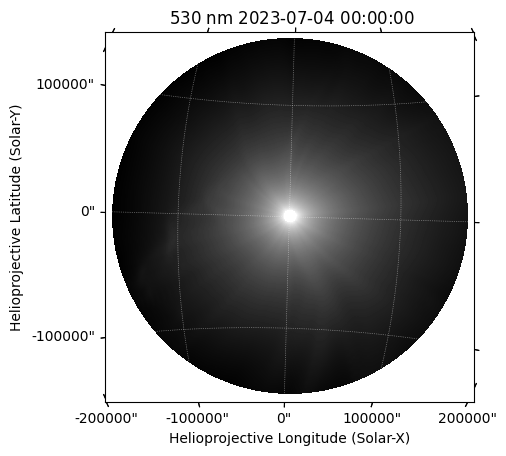

In [41]:
# Plot the data using the SunPy Map object plotting function

data_map.plot(norm='log')

In [39]:
# Construct an NDCube object out of this data

data_ndcube = NDCube(data, wcs=data_wcs)

data_ndcube

NDCube
------
Dimensions: [2.000e+00 4.096e+03 4.096e+03] pix
Physical Types of Axes: [('phys.polarization.stokes',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float32